In [1]:
import json
import pandas

## Load data

In [2]:
# Incoming transfer packages

# raw_incoming_transfer_packages_dataframe_1 = pandas.read_excel('data/royal/20210926/royal_apothecary_incoming_transfer_packages_20200101_20201231.xlsx', header=0)
# raw_incoming_transfer_packages_dataframe_2 = pandas.read_excel('data/royal/20210926/royal_apothecary_incoming_transfer_packages_20210101_20210926.xlsx', header=0)
# raw_incoming_transfer_packages_dataframe = pandas.concat([
#     raw_incoming_transfer_packages_dataframe_1,
#     raw_incoming_transfer_packages_dataframe_2,
# ])

raw_incoming_transfer_packages_dataframe = pandas.read_excel('data/royal/20210926/royal_apothecary_incoming_transfer_packages_20200101_20210926.xlsx', header=0)
print(f'Loaded in {len(raw_incoming_transfer_packages_dataframe.index)} incoming transfer packages...')

/Users/warren/venvs/bespoke/lib/python3.7/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Loaded in 5484 incoming transfer packages...


In [3]:
# Sales transactions

raw_sales_transactions_dataframe_1 = pandas.read_excel('data/royal/20210926/royal_apothecary_sales_transactions_20200101_20200630.xlsx', header=0)
raw_sales_transactions_dataframe_2 = pandas.read_excel('data/royal/20210926/royal_apothecary_sales_transactions_20200701_20201231.xlsx', header=0)
raw_sales_transactions_dataframe_3 = pandas.read_excel('data/royal/20210926/royal_apothecary_sales_transactions_20210101_20210531.xlsx', header=0)
raw_sales_transactions_dataframe_4 = pandas.read_excel('data/royal/20210926/royal_apothecary_sales_transactions_20210601_20210926.xlsx', header=0)
raw_sales_transactions_dataframe = pandas.concat([
    raw_sales_transactions_dataframe_1,
    raw_sales_transactions_dataframe_2,
    raw_sales_transactions_dataframe_3,
    raw_sales_transactions_dataframe_4,
])
print(f'Loaded in {len(raw_sales_transactions_dataframe.index)} sales transactions...')

Loaded in 107177 sales transactions...


In [4]:
# Active inventory

raw_active_inventory_packages_dataframe = pandas.read_excel('data/royal/20210926/royal_apothecary_active_inventory_20210928.xlsx', header=0)
print(f'Loaded in {len(raw_active_inventory_packages_dataframe.index)} active inventory packages...')

Loaded in 3364 active inventory packages...


## Format data

In [26]:
incoming_transfer_packages_dataframe = raw_incoming_transfer_packages_dataframe[[
#     'date_type',
#     'transfer_row_id',
#     'delivery_row_id',
#     'package_row_id',
    'delivery_type',
    'manifest_number',
    'created_date',
    'received_datetime',
    'shipper_facility_license_number',
    'shipper_facility_name',
    'recipient_facility_license_number',
    'recipient_facility_name',
    'shipment_type_name',
    'shipment_transaction_type',
    'package_id',
    'package_label',
    'type',
    'product_category_name',
    'product_name',
    'shipper_wholesale_price',
    'shipped_quantity',
    'package_lab_results_status',
    'shipment_package_state',
    'is_testing_sample',
    'is_trade_sample'
]]

sales_transactions_dataframe = raw_sales_transactions_dataframe[[
#     'date_type',
#     'id',
    'receipt_id',
    'receipt_number',
#     'receipt_type',
    'sales_customer_type',
    'sales_datetime',
    'total_packages',
    'total_price',
    'tx_type',
    'tx_package_id',
    'tx_package_label',
    'tx_product_name',
    'tx_product_category_name',
    'tx_unit_of_measure',
    'tx_quantity_sold',
    'tx_total_price',
]]
sales_transactions_dataframe = sales_transactions_dataframe.rename(columns={'tx_package_id': 'package_id'})

active_inventory_packages_dataframe = raw_active_inventory_packages_dataframe[[
    'identifier',
    'license_number',
    'last_modified_at',
    'package_id',
    'package_label',
    'type',
    'packaged_date',
    'package_type',
    'product_name',
    'product_category_name',
    'quantity',
    'unit_of_measure'
]]

In [27]:
fn = lambda row: f'{row.shipper_facility_name} ({row.shipper_facility_license_number})'
col = incoming_transfer_packages_dataframe.apply(fn, axis=1)
incoming_transfer_packages_dataframe = incoming_transfer_packages_dataframe.assign(shipper_facility=col.values)

fn = lambda row: f'{row.created_date.year}-{"0" if row.created_date.month < 10 else ""}{row.created_date.month}'
col = incoming_transfer_packages_dataframe.apply(fn, axis=1)
incoming_transfer_packages_dataframe = incoming_transfer_packages_dataframe.assign(created_month=col.values)

fn = lambda row: f'{row.sales_datetime.year}-{"0" if row.sales_datetime.month < 10 else ""}{row.sales_datetime.month}'
col = sales_transactions_dataframe.apply(fn, axis=1)
sales_transactions_dataframe = sales_transactions_dataframe.assign(sales_month=col.values)

fn = lambda row: f'{row.sales_datetime.year}-{"0" if row.sales_datetime.month < 10 else ""}{row.sales_datetime.month}-{"0" if row.sales_datetime.day < 10 else ""}{row.sales_datetime.day}'
col = sales_transactions_dataframe.apply(fn, axis=1)
sales_transactions_dataframe = sales_transactions_dataframe.assign(sales_date=col.values)

In [28]:
incoming_transfer_packages_dataframe.columns

Index(['delivery_type', 'manifest_number', 'created_date', 'received_datetime',
       'shipper_facility_license_number', 'shipper_facility_name',
       'recipient_facility_license_number', 'recipient_facility_name',
       'shipment_type_name', 'shipment_transaction_type', 'package_id',
       'package_label', 'type', 'product_category_name', 'product_name',
       'shipper_wholesale_price', 'shipped_quantity',
       'package_lab_results_status', 'shipment_package_state',
       'is_testing_sample', 'is_trade_sample', 'shipper_facility',
       'created_month'],
      dtype='object')

## Filter data

In [54]:
filter_by_sales_year = None
filter_by_sales_year = (sales_transactions_dataframe['sales_month'] >= '2021-01') & (sales_transactions_dataframe['sales_month'] < '2022-01')


In [49]:
# Note: we filter OUT incoming transfers if any of the following are true:
# 1. Package shipment package state is NOT Accepted.
# 2. Product name contains "Trade" or "Sample" in it. NOT IMPLEMENTED YET
# 3. Package wholesale shipper price is $0.01 AND shipped quantity is 1.
incoming_transfer_packages_dataframe = incoming_transfer_packages_dataframe[
    incoming_transfer_packages_dataframe['shipment_package_state'] == 'Accepted'
][
    (incoming_transfer_packages_dataframe['shipper_wholesale_price'] != 0.01) | (incoming_transfer_packages_dataframe['shipped_quantity'] != 1)
]
print(f'# filtered incoming transfer packages: {len(incoming_transfer_packages_dataframe)}')

# filtered incoming transfer packages: 4466


In [50]:
incoming_transfer_packages_dataframe.columns

Index(['delivery_type', 'manifest_number', 'created_date', 'received_datetime',
       'shipper_facility_license_number', 'shipper_facility_name',
       'recipient_facility_license_number', 'recipient_facility_name',
       'shipment_type_name', 'shipment_transaction_type', 'package_id',
       'package_label', 'type', 'product_category_name', 'product_name',
       'shipper_wholesale_price', 'shipped_quantity',
       'package_lab_results_status', 'shipment_package_state',
       'is_testing_sample', 'is_trade_sample', 'shipper_facility',
       'created_month'],
      dtype='object')

In [55]:
# Note: we filter OUT sales transactions if any of the following are true:
# 1. Sales price is $0.01.
sales_transactions_dataframe = sales_transactions_dataframe[
    sales_transactions_dataframe['tx_total_price'] != 0.01
]
if filter_by_sales_year is not None:
    sales_transactions_dataframe = sales_transactions_dataframe[
        filter_by_sales_year
    ]
print(f'# filtered sales transactions: {len(sales_transactions_dataframe)}')

# filtered sales transactions: 57327


In [38]:
# TODO: filter active inventory?

## Join data

In [56]:
sales_transaction_with_incoming_transfer_packages_dataframe = sales_transactions_dataframe.join(incoming_transfer_packages_dataframe.set_index('package_id'), on='package_id', how='inner', lsuffix='_l', rsuffix='_r')
print(f'# sales transactions with associated incoming transfer package: {len(sales_transaction_with_incoming_transfer_packages_dataframe.index)} ({len(sales_transaction_with_incoming_transfer_packages_dataframe.index) / len(sales_transactions_dataframe.index) * 100}%)')


# sales transactions with associated incoming transfer package: 56302 (98.21201179200028%)


In [58]:
sales_transaction_with_incoming_transfer_packages_dataframe = sales_transaction_with_incoming_transfer_packages_dataframe[[
#     'manifest_number',
    'package_id',
    'package_label',
    'created_month',
    'created_date',
    'shipper_facility',
    'shipper_facility_license_number',
    'shipper_facility_name',
    'shipper_wholesale_price',
    'shipped_quantity',
    'sales_month',
    'sales_date',
    'sales_datetime',
    'tx_product_name',
    'tx_product_category_name',
    'tx_unit_of_measure',
    'tx_quantity_sold',
    'tx_total_price',
]]

In [59]:
active_inventory_packages_with_incoming_transfer_packages_dataframe = active_inventory_packages_dataframe.join(incoming_transfer_packages_dataframe.set_index('package_id'), on='package_id', how='inner', lsuffix='_l', rsuffix='_r')
print(f'# active inventory packages with associated transfer package: {len(active_inventory_packages_with_incoming_transfer_packages_dataframe.index)} ({len(active_inventory_packages_with_incoming_transfer_packages_dataframe.index) / len(active_inventory_packages_dataframe.index) * 100}%)')


# active inventory packages with associated transfer package: 2600 (77.28894173602853%)


## Analyze data

1. What are the top selling products with over 2 purchased packages? In 2020 vs 2021? GMV? Margin?

<AxesSubplot:xlabel='tx_product_category_name,tx_product_name'>

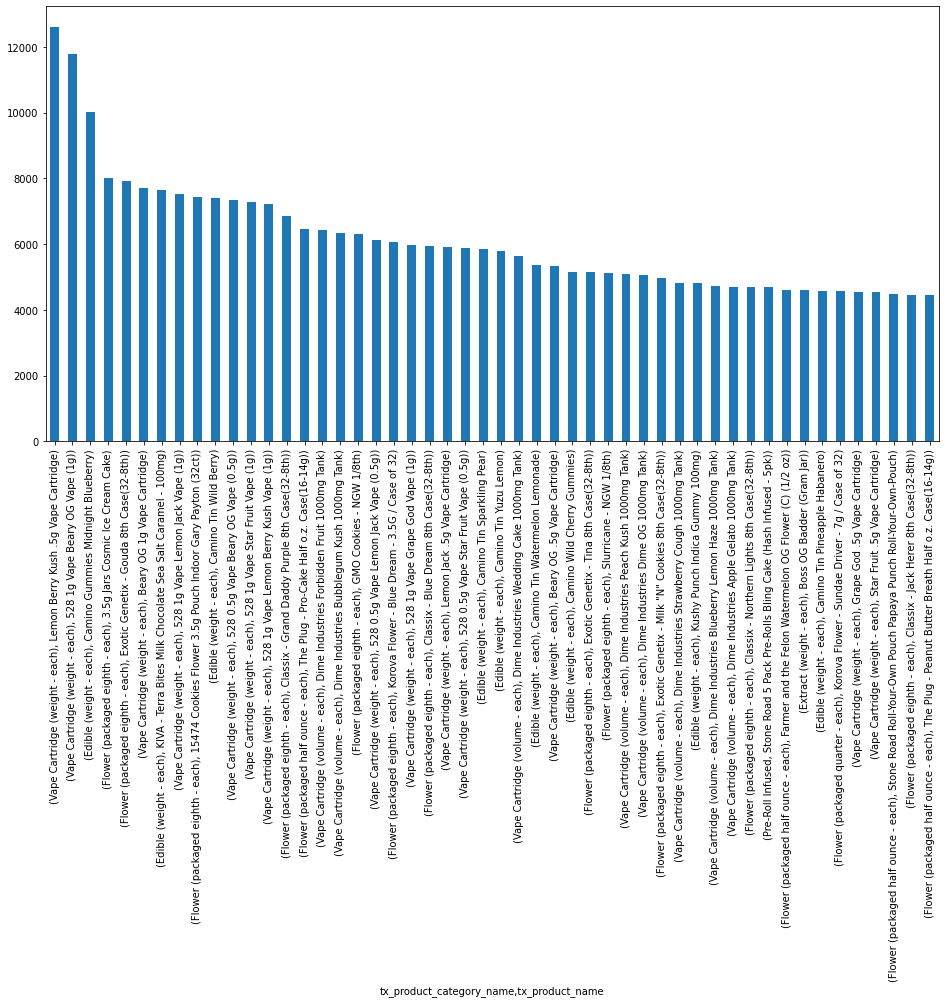

In [76]:
# Top 50 products by GMV
top_50_products_by_gmv_dataframe = sales_transactions_dataframe.groupby(['tx_product_category_name', 'tx_product_name'])['tx_total_price'].sum().sort_values(ascending=False).head(50)
top_50_products_by_gmv_dataframe.plot(figsize=(16, 8), kind='bar')

In [77]:
import time

xlsx_file_name = f'~/Downloads/top_50_products_by_gmv_{round(time.time())}.xlsx'
top_50_products_by_gmv_dataframe.to_excel(xlsx_file_name)

<AxesSubplot:xlabel='product_category_name,product_name'>

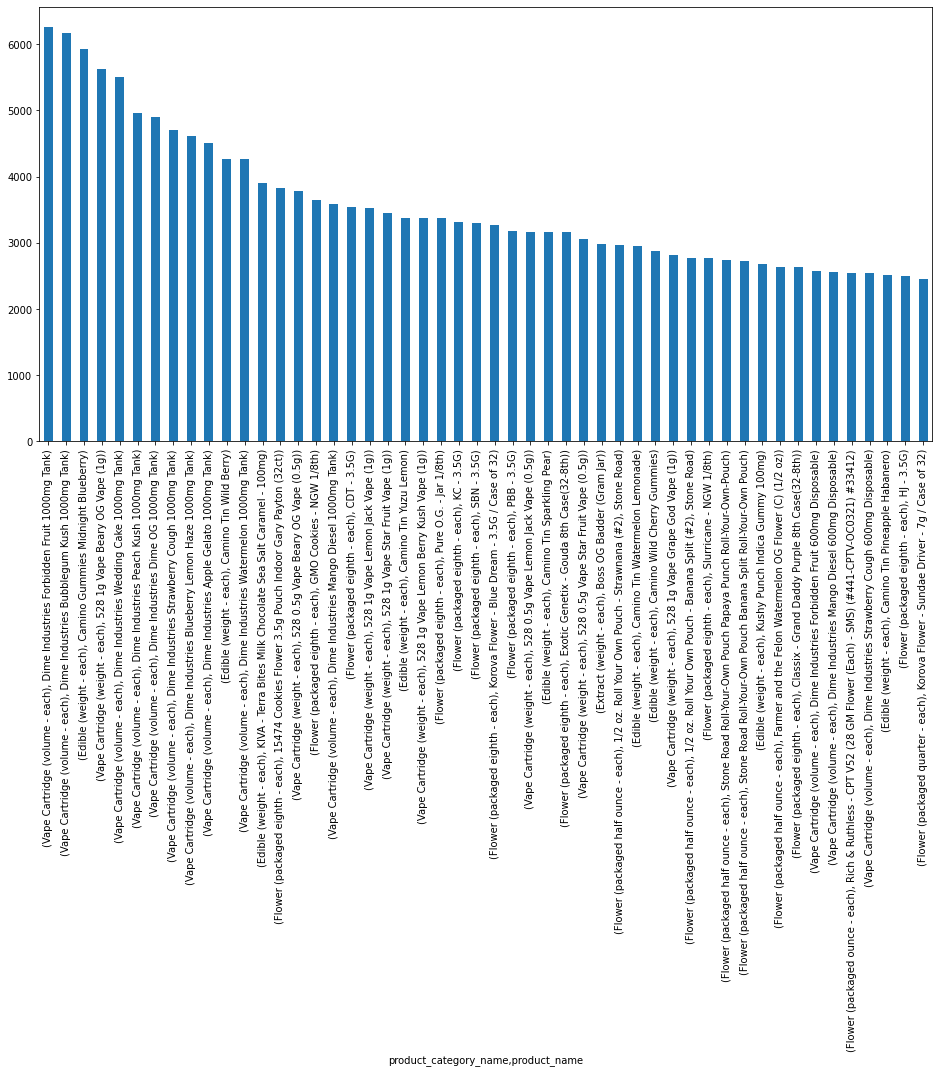

In [73]:
# Top 50 products by profit

sales_transaction_with_incoming_transfer_package_records = sales_transaction_with_incoming_transfer_packages_dataframe.to_dict('records')

sales_transaction_with_margins = []

for sales_transaction_with_incoming_transfer_package_record in sales_transaction_with_incoming_transfer_package_records:
    product_category_name = sales_transaction_with_incoming_transfer_package_record['tx_product_category_name']
    product_name = sales_transaction_with_incoming_transfer_package_record['tx_product_name']
    
    shipped_quantity = sales_transaction_with_incoming_transfer_package_record['shipped_quantity']
    shipper_wholesale_price = sales_transaction_with_incoming_transfer_package_record['shipper_wholesale_price']
    per_unit_cost = shipper_wholesale_price / shipped_quantity
    
    sold_quantity = sales_transaction_with_incoming_transfer_package_record['tx_quantity_sold']
    sold_price = sales_transaction_with_incoming_transfer_package_record['tx_total_price']
    per_unit_price = sold_price / sold_quantity

    per_unit_margin = (per_unit_price - per_unit_cost)
    sales_transaction_profit = per_unit_margin * sold_quantity

    sales_transaction_with_margins += [(
        product_category_name,
        product_name,
        sales_transaction_profit
    )]

sales_transaction_with_margins_dataframe = pandas.DataFrame(
    sales_transaction_with_margins,
    columns=[
        'product_category_name',
        'product_name',
        'sales_transaction_profit',
    ],
)

top_50_products_by_profit_dataframe = sales_transaction_with_margins_dataframe.groupby(['product_category_name', 'product_name'])['sales_transaction_profit'].sum().sort_values(ascending=False).head(50)
top_50_products_by_profit_dataframe.plot(figsize=(16, 8), kind='bar')

In [75]:
import time

xlsx_file_name = f'~/Downloads/top_50_products_by_profit_{round(time.time())}.xlsx'
top_50_products_by_profit_dataframe.reset_index().to_excel(xlsx_file_name)